## ICESat-2 Filtering and Visualization
This notebook searches for a spatial subset of data, runs DPS jobs to extract_atl08.py (by Nathan Thomas & Paul Montesano), processing and visualizing the outputs. Set up a notebook run in the first cell, especially whether or not DPS jobs should be submitted.

Outline:
1. Get BBOX of interest
2. Query CMR for ATL08 Granules
3. Convert ATL08 Granules to las format only keeping relevant vars/dimensions (h5py/pdal)
4. Convert las files to EPT data store

In [64]:
# 2.3 ICESat-2 extraction, merging, filtering, exploring, mapping
from maap.maap import MAAP
maap = MAAP()

import ipycmc
w = ipycmc.MapCMC()

import importlib
lib_loader = importlib.find_loader('cartopy')

if lib_loader is not None:
    REBUILD_CONDA_ENV = False
    print("No need to re-build conda env.")
else:
    REBUILD_CONDA_ENV = True
    print("Re-build conda env...")

if REBUILD_CONDA_ENV:
    #### This notebook uses a DPS job to run extract_atl08.py to convert h5's to csv's, then appends all csv's into a pandas geodataframe.
    #### Returns: a pandas geodataframe that should hold the entire set of ATL08 data for this project
    #### Notes:
    ###### ISSUE: how to relaibly activate a conda env that can support this notebook.
    ###### Need to 'conda activate' an env that has geopandas - but where do I do this 'activate'. How does terminal env interact with nb?
    ###### Workaround: always do this to base:
    ! conda install -c conda-forge geopandas -y
    #! conda install -c conda-forge cartopy -y
    ! conda install -c conda-forge descartes -y
    ! conda install -c conda-forge seaborn -y
    ! conda install contextily --channel conda-forge -y
    #! conda install -c conda-forge matplotlib_scalebar -y
    ##https://www.essoar.org/doi/10.1002/essoar.10501423.1
    ##https://www.essoar.org/pdfjs/10.1002/essoar.10501423.1
    ##https://github.com/icesat2py/icepyx/blob/master/examples/ICESat-2_DEM_comparison_Colombia_working.ipynb
    ##https://github.com/ICESAT-2HackWeek/2020_ICESat-2_Hackweek_Tutorials
    ##https://icesat-2hackweek.github.io/learning-resources/logistics/schedule/
    ##https://github.com/giswqs/earthengine-py-notebooks

# Notes:
# Basic filtering themes in invoke below, and remove from extract_atl08.py
# snow has impact on errors - remove snow data (summer only)
# msw = 0
# beams 1 & 5 strong (better radiometric perf, sensitive), then beam 3

import geopandas as gpd
import descartes
import numpy as np
import seaborn as sb
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import pandas as pd
import glob
import os
import random 
import shutil
import time
import math

import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import datetime
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

import FilterUtils

# Run extract_at08.py as a DPS job (see nb 1.3 for template of how this can be done)
#DPS_OUTPUT_DIR = '/projects/r2d2/output_23'
DPS_OUTPUT_DIR = '/projects/above/processed_data/2.3_output'
#DPS_OUTPUT_DIR = '/projects/jabba/dps_output'
#DPS_OUTPUT_DIR = '/projects/jabba/data/bbox_alaska'

EPT_APPROACH = False

H_DIFF_THRESH = 100
H_CAN_THRESH = 100
RUN_DPS = False
READ_PICKLE = True
DIR_PICKLE = '/projects/jabba/data'#'/projects/above'

DO_ATL08_CSV_SUBSET = True # <- set to True for testing
SUBSET_FRAC_SIZE = 0.10

#COPY_CSVS = False
CSV_TO_DIR = "/projects/r2d2/above/atl08_csvs"
%matplotlib inline

Re-build conda env...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

Deprecated since Python 3.4. Use importlib.util.find_spec() instead.



Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [3]:
def get_granules_list(granules):
    url_list = []
    output_list = []
    for res in granules:
        url_list.append(res.getDownloadUrl())

    for url in url_list:
        if url[0:5] == 's3://':
            url = url[5:].split('/')
            url[0] += '.s3.amazonaws.com'
            url = 'https://' + '/'.join(url)
        output_list.append(url)
    return output_list

## Run a test DPS job on a single file

In [4]:
if RUN_DPS:
    # Get list of ATL08 granules of interest
    BBOX_NA = "-180,50,-50,75"
    BBOX_CIRC = "-180,40,180,75" # You'll need to edit run_above.sh to adjust the geo filtering called for with extract_atl08.py
    YEAR = '2019'
    COLLECTID_ATL08_V3 = "C1200235747-NASA_MAAP"

    # Note: we want to be able to do a 'recurring' seasonal search, regardless of year
    DATERANGE_SUMMER = YEAR+'-06-01T00:00:00Z,'+YEAR+'-09-30T23:59:59Z'

    # We dont really want a limit: Not really sure how to set this; just use very high number?
    MAX_ATL08_ORBITS = 100000

    granules = maap.searchGranule(collection_concept_id=COLLECTID_ATL08_V3, 
                                  temporal=DATERANGE_SUMMER, 
                                  bounding_box=BBOX_CIRC, 
                                  limit=MAX_ATL08_ORBITS)
    #pprint(granules[0], depth=2)

    # This is a list of the granule URLs for processing
    granules_list_ATL08 = get_granules_list(granules)

    ##################################
    #Test DPS submission on a single file
    granule=granules_list_ATL08[0]

    submit_result = maap.submitJob(identifier="nothing", algo_id="run_above_ubuntu", 
                                       version="master", 
                                       username="r2d2", 
                                       icesat2_granule=granule)
    print(submit_result)

## Run DPS in Batch Mode

In [5]:
# Extraction
#
# DPS SUBMISSION
if RUN_DPS:
    # Here is where I submit a job 
    # identified with 'algo_id' (in yaml file)
    # that specifies a bash script /projects/above/gitlab_repos/atl08_extract_repo/run_above.sh 
    # that will call the 'algorithm' (extract_atl08.py)

    # Uses granule list from nb 2.1
    # CHANGE the submitJob args!
    for g in range(len(granules_list_ATL08)):
        granule = granules_list_ATL08[g]
        submit_result = maap.submitJob(identifier="nothing", algo_id="run_above_ubuntu", 
                                   version="master", 
                                   username="r2d2", 
                                   icesat2_granule=granule)
        if g == 1:
            print(submit_result)
        if g == 100:
            print (submit_result)
        if g == 1000:
            print (submit_result)
        if g == 2000:
            print (submit_result)
        if g == 3000:
            print (submit_result)
        if g == 4000:
            print (submit_result)
        if g == len(granules_list_ATL08):
            print (submit_result)
            print ('done!')
        
else:
    print("Not running DPS; probably because output from extract_atl08 DPS job already exists.")
    print(DPS_OUTPUT_DIR)

Not running DPS; probably because output from extract_atl08 DPS job already exists.
/projects/above/processed_data/2.3_output


## Combine DPS outputs into data frame for visualizatioon

In [6]:
%%time

if not READ_PICKLE:
    # Merging
    # Merging via glob.glob not recommended due to slow processing. Instead copy files into a now s3 bucket
    # e.g. any directory not under user name
    # Note if file volumes too large this will fill memory on shared instance, so better longterm solution needed.
    # Copy files in terminal:
    #find /projects/r2d2/dps_output/run_above_ubuntu/master/2021/03/02/04/ -name "*.csv" -type f | xargs -n 1 -P 4 -I{} cp -v {} /projects/above/processed_data/2.3_output
    # Merge all CSV from extract_at08.py into a dataframe
    #
    # NOTE: If the ATL08 subset files that we process with extract_atl08.py are h5 files (instead of CSVs), we need to update this.
    # FOLLOW-UP NOTE (5/27/2021): The EPT (Entwince Point Tile) Approach will access the H5 files directly and return a large filtered DF
    :
    print("Making list of ATL08 csv files...hang in there...")
    # Find and delete any CSV that has a size of 0
    #! find $DPS_OUTPUT_DIR -name "*.csv" -size 0 -delete

    # Find all remaining output CSVs from DPS jobs
    all_atl08_csvs = glob.glob(DPS_OUTPUT_DIR+"/ATL08*.csv", recursive=True)

    print("# of ATL08 files: ",len(all_atl08_csvs))

    # This could break if you randomly grab an incomplete or empty CSV
    if DO_ATL08_CSV_SUBSET:
        all_atl08_csvs = random.sample(all_atl08_csvs, math.floor(SUBSET_FRAC_SIZE * len(all_atl08_csvs)))
        print("# of ATL08 files after test sample: ",len(all_atl08_csvs))

    # Merge all files in the list
    print("Creating pandas data frame...")
    atl08 = pd.concat([pd.read_csv(f) for f in all_atl08_csvs ], sort=False)

    print("\nPre-filter data cleaning...")
    print("\nGet beam type from orbit orientation and ground track...") 
    atl08.loc[( (atl08.orb_orient == 1 ) & (atl08['gt'].str.contains('r')) ), "beam_type"] = 'Strong' 
    atl08.loc[( (atl08.orb_orient == 1 ) & (atl08['gt'].str.contains('l')) ), "beam_type"] = 'Weak'
    atl08.loc[( (atl08.orb_orient == 0 ) & (atl08['gt'].str.contains('r')) ), "beam_type"] = 'Weak'
    atl08.loc[( (atl08.orb_orient == 0 ) & (atl08['gt'].str.contains('l')) ), "beam_type"] = 'Strong'
    print(atl08.beam_type.unique())

    cols_float = ['lat', 'lon', 'h_can', 'h_te_best', 'ter_slp'] 
    print(f"Cast some columns to type float: {cols_float}")
    atl08[cols_float] = atl08[cols_float].apply(pd.to_numeric, errors='coerce')

    cols_int = ['n_ca_ph', 'n_seg_ph', 'n_toc_ph']
    print(f"Cast some columns to type integer: {cols_int}")
    atl08[cols_int] = atl08[cols_int].apply(pd.to_numeric, downcast='signed', errors='coerce')

    #Get rid of b strings and convert to int, then datetime
    atl08['yr'] = atl08['yr'].str.strip("b\'\"").astype(int)
    atl08['m'] = atl08['m'].str.strip("b\'\"").astype(int)
    atl08['d'] = atl08['d'].str.strip("b\'\"").astype(int)
    atl08["date"] = pd.to_datetime(atl08["yr"]*1000 + atl08["d"], format = "%Y%j")
    print(atl08.info())
    
    # Probably not necessary
    #print('finished pickle') #<--no; there isnt any pickling here; its written aftern the Filtering chunk
    #atl08.to_csv( "/projects/above/processed_data/atl08_merged.csv", index=False, encoding='utf-8-sig')

Making list of ATL08 csv files...hang in there...
# of ATL08 files:  6718
# of ATL08 files after test sample:  671
Creating pandas data frame...

Pre-filter data cleaning...

Get beam type from orbit orientation and ground track...
['Weak' 'Strong']
Cast some columns to type float: ['lat', 'lon', 'h_can', 'h_te_best', 'ter_slp']
Cast some columns to type integer: ['n_ca_ph', 'n_seg_ph', 'n_toc_ph']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19339801 entries, 0 to 3779
Data columns (total 56 columns):
fid            int64
lon            float64
lat            float64
yr             int64
m              int64
d              int64
orb_orient     int64
orb_num        int64
rgt            int64
gt             object
segid_beg      int64
segid_end      int64
h_max_can      float64
h_can          float64
rh25           float64
rh50           float64
rh60           float64
rh70           float64
rh75           float64
rh80           float64
rh85           float64
rh90           float64


In [20]:
if not READ_PICKLE and not EPT_APPROACH:
    # Filtering    <------ THIS IS UPDATED USING THE METHOD IN FilterUtils.py (~5-26-2021)
    #
    MONTH_MIN = atl08.m.unique().min()
    MONTH_MAX = atl08.m.unique().max()

    print("\nFiltering for quality: for clear skies, h_can < {}, months {}-{}, strong beams, and snow free land...".format(H_CAN_THRESH, MONTH_MIN, MONTH_MAX))
    atl08 =  atl08[
                   (atl08.msw_flg == 0) & 
                   (atl08.h_can < H_CAN_THRESH) &
                   #(atl08.m >= MONTH_MIN ) & (atl08.m <= MONTH_MAX) &
                   #(atl08.m == int(MONTH_ATL08.to_string()) )
                   (atl08.beam_type == 'Strong') & 
                    (atl08.seg_snow == 'snow free land')
                    ]
    print(f"After filtering, there are {atl08.shape[0]} observations in this dataframe.")

    # Pickle the file
    cur_time = time.strftime("%Y%m%d%H%M%S")
    atl08.to_pickle(os.path.join(DIR_PICKLE, "atl08_filt_"+cur_time+".pkl"))
else:
    print("Getting the latest merged, filtered, & compressed file of ATL08 obs as a pandas dataframe...")
    list_of_pickles = glob.glob(DIR_PICKLE+'/atl08*.pkl') # * means all if need specific format then *.csv
    latest_pickle_file = max(list_of_pickles, key=os.path.getctime)
    print(latest_pickle_file)
    atl08 = pd.read_pickle(latest_pickle_file)
    print("ATL08 db now available from pickled file.")


Getting the latest merged, filtered, & compressed file of ATL08 obs as a pandas dataframe...
/projects/jabba/data/atl08_filt_20210302212944.pkl


In [73]:
%%time
from FilterUtils import filter_atl08
# Filter using FilterUtils
print("Applying additional filtering using FilterUtils; returning a final atl08 dataframe...")

if EPT_APPROACH:
    # INPUT EPT APPROACH HERE to return a filtered atl08 data frame?
    # https://docs.maap-project.org/en/latest/query/testing-ept-stores.html
    
    # Read a massive EPT file of all ATL08 h5 files
    
    if True:
        # By tile: EPT is filtered using 2.3_dps.py to subset by tile and filter with above_filter_atl08() function in FilterUtils.py
        atl08 = FilterUtils.filter_atl08_ept(in_ept_fn, in_tile_fn, in_tile_num, in_tile_layer, output_dir, return_pdf=True)
    else:
        # By entire EPT dB (not practical)
        # -- Not yet implemented --
        next

else:
    #atl08 = FilterUtils.filter_atl08(atl08, SUBSET_COLS=False, filt_cols=['h_can','h_dif_ref','m','msw_flg','beam_type','seg_snow'], thresh_h_can=100, thresh_h_dif=100, month_min=6, month_max=9)
    atl08_tmp = filter_atl08(atl08, SUBSET_COLS=True, filt_cols=['h_can','h_dif_ref','m','msw_flg','beam_type','seg_snow'], thresh_h_can=100, thresh_h_dif=100, month_min=6, month_max=9)


ImportError: cannot import name 'filter_atl08' from 'FilterUtils' (/projects/code/icesat2_boreal/notebooks/2.ICESat-2 processing/FilterUtils.py)

In [ ]:
## Plot out summary of Processed Data

# of ATL08 columns:  56
There are 1287826 observations in this dataframe.
Max lat: 79.99034118652344
Min lat: 40.0000228881836
Max lon: 179.99832153320312
Min lon: -179.9787139892578
Years:  [2019 2020]
Months:  [6 9 8 7]

Example 1: Get only clear sky data, by year, with ht threshold.

There are 790631 observations in day.

There are 497195 observations in night.


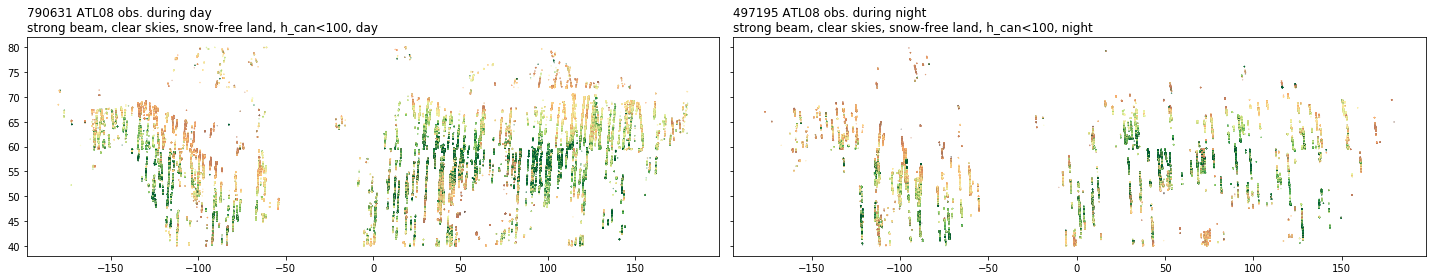

In [12]:
# Exploring filtered ATL08 with plots
print("# of ATL08 columns: ", len(atl08.columns))
print(f"There are {atl08.shape[0]} observations in this dataframe.")
#print("Col names: ", atl08.columns)
print("Max lat:",    atl08.lat.max())
print("Min lat:",    atl08.lat.min())
print("Max lon:",    atl08.lon.max())
print("Min lon:",    atl08.lon.min())
print("Years: ",     atl08.yr.unique())
print("Months: ",    atl08.m.unique())

# Plot obs from night and day
# My cmap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

print("\nExample 1: Get only clear sky data, by year, with ht threshold.")

fig, axes = plt.subplots(nrows=1, ncols=atl08.night_flg.nunique(), figsize=(20, 4), sharex=False, sharey=True)
#ax0, ax1, ax2, ax3 = axes.flatten()

SAMP_FRAC = 1 # Map just a portion of the data for speed

i=0
for group_name, group in atl08.groupby('night_flg'):
    print(f"\nThere are {len(group)} observations in {group_name}.")
    #print(f"Filtering for clear skies and h_can < 60")
    #group_tmp = group[ 
    #                  (group.seg_snow == 'snow free land') 
    #                 ].sample(frac=SAMP_FRAC)

    #prop_of_df = round(len(group_tmp) / len(atl08), 3)

    #print(f"Proportion of {group_name} total satifying this filter: {prop_of_df}")
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    scat = axes[i].scatter(x=group.lon, y=group.lat, c=group['h_can'], cmap = forest_ht_cmap, vmin=0, vmax=25, s=0.05)
    #subplt = group.plot(ax=axes[i], x='lon', y='lat', c='h_can', cmap = forest_ht_cmap, vmin=0, vmax=25, kind='scatter', s=0.05) # 
    axes[i].set_title(str(len(group))+" ATL08 obs. during "+group_name+"\nstrong beam, clear skies, snow-free land, h_can<"+str(H_CAN_THRESH)+", "+group_name
                      #+"\n"+str(round(prop_of_df*100,1)) +"% of data"
                      , loc='left')
    #cbar = plt.colorbar(scat, extend='max', spacing='proportional', orientation='vertical', shrink=0.7, format="%.0f")
    #cbar.set_label(label = 'Canopy height (m)', size=16)

    i+=1

plt.tight_layout()


1287826


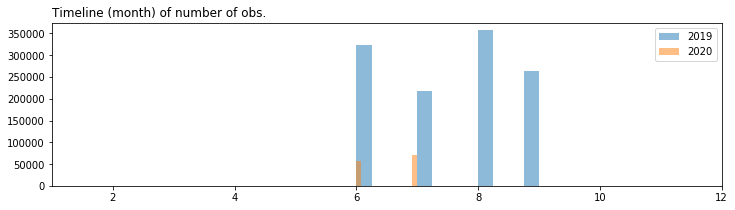

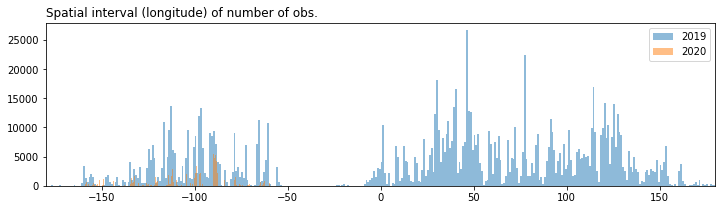

In [13]:
# Simple histogram plotting is **ridiculously** hard to get correct.
#
# here, i try to plot a timeline of the count of ATL08, by day and month, for each year.
f, ax = plt.subplots(1,1,figsize=(12,3))
#atl08['fid'].groupby([atl08["date"].dt.year, atl08["date"].dt.month, atl08["date"].dt.day]).count().plot(ax=ax, kind='bar')

df = atl08.sample(frac=1)
print(len(df))
for i, seg_name in enumerate(df.yr.unique()):
    #ax.hist(atl08[atl08.yr == seg_name].groupby([atl08["date"].dt.month, atl08["date"].dt.day]), bins=bins, alpha=0.5, label=seg_name)
    ax.hist(df[df.yr == seg_name].m, bins=12, alpha=0.5, label=seg_name)
    ax.set_title(f"Timeline (month) of number of obs.", loc='left')
    ax.legend()
    ax.set_xlim(1, 12)
f, ax = plt.subplots(1,1,figsize=(12,3)) 
for i, seg_name in enumerate(df.yr.unique()):
    #ax.hist(atl08[atl08.yr == seg_name].groupby([atl08["date"].dt.month, atl08["date"].dt.day]), bins=bins, alpha=0.5, label=seg_name)
    ax.hist(df[df.yr == seg_name].lon, bins=360, alpha=0.5, label=seg_name)
    ax.set_title(f"Spatial interval (longitude) of number of obs.", loc='left')
    ax.legend()
    ax.set_xlim(-180, 180)

if False:
    # Good luck with getting this plot...
    f, ax = plt.subplots(2,1,figsize=(12,3), sharex=True, sharey=True)
    i=0
    for group_name, group in atl08.groupby('yr'):
        group['m'].groupby([group["date"].dt.month, group["date"].dt.day]).count().plot(ax=ax[i], kind='bar')
        ax[i].set_title(group_name, 
                        loc='left')
        i+=1
#plt.xlabel('Date', fontsize=12)
#plt.xticks(fontsize=7, rotation=90)

(0, 150)

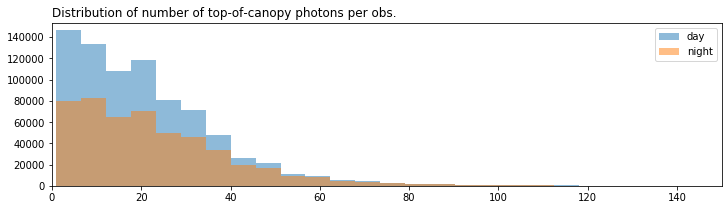

In [14]:
# Use the same bins for each
xmin = atl08.n_toc_ph.min()
xmax = atl08.n_toc_ph.max()
bins = np.linspace(xmin, xmax, 300)

# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(figsize=(12,3))

for i, seg_name in enumerate(atl08.night_flg.unique()):
    ax.hist(atl08[atl08.night_flg == seg_name].n_toc_ph, bins=bins, alpha=0.5, label=seg_name)
    ax.set_title("Distribution of number of top-of-canopy photons per obs.", loc='left')
    ax.legend()

# same xlim for each so we can see differences
ax.set_xlim(0, 150)


In [16]:
# CREATE GEOPANDAS DATAFRAME WITH SPATIAL REF and sample a fractions of it.
#
SAMP_FRAC=1
atl08_gdf = GeoDataFrame(atl08, geometry=gpd.points_from_xy(atl08.lon, atl08.lat), crs='epsg:4326').sample(frac=SAMP_FRAC)
print(f"There are {atl08_gdf.shape[0]} ATL08 observations in this sampled ({100*SAMP_FRAC}%) Geodataframe.")
print(len(atl08_gdf.columns))
xmin, ymin, xmax, ymax = atl08_gdf.total_bounds

# Subset to save for testing
bbox_sub = [-102.7684,40,-97,32037,47.48166]
atl08_gdf_sub = atl08_gdf.cx[bbox_sub[0]:bbox_sub[2], bbox_sub[1]:bbox_sub[3]]
atl08_gdf_sub.to_csv(os.path.split(CSV_TO_DIR)[0]+"/atl08_gdf_sub.csv", index=False, encoding="utf-8-sig")

There are 1287826 ATL08 observations in this sampled (100%) Geodataframe.
57


## Plot Filtered ICESat-2 Data for Domain

In [30]:
# Define a projection for the maps and the geodataframe

# Compare two equal area prjs
# https://map-projections.net/compare.php?p1=albers-equal-area-conic&p2=azimutal-equal-area-gpolar

# These albers prjs dont split the continents polygon well.
# boreal albers projection
#boreal_alb = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=60 +lon_0=-170 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
#na_alb =     "+proj=aea +lat_1=50 +lat_2=70 +lat_0=60 +lon_0=-110 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"



# https://proj.org/operations/projections/stere.html
boreal_stero = "+proj=stere +lat_0=90 +lat_ts=71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

# https://proj.org/operations/projections/laea.html
northpole_laea = "+proj=laea +lat_0=60 +lon_0=-180 +x_0=90 +y_0=0 +ellps=GRS80" # +datum=NAD83 +units=m +no_defs"

proj = northpole_laea

#if atl08_gdf.lon.min() < 0:
#    proj_alb = boreal_alb

# Clip world to ATL08 gdf
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_atl08 = world.cx[xmin:xmax, ymin:ymax]
atl08_gdf_chull = atl08_gdf.unary_union.convex_hull

world_atl08 = world[world.intersects(atl08_gdf_chull)]
#NA = world[world['continent'] == 'North America'].to_crs(boreal_alb)

atl08_gdf_aea = atl08_gdf.to_crs(proj)
world_atl08_aea = world_atl08.to_crs(proj)

/projects/above/processed_data/2.3_output/atl08_alb_h_can_2019_2020_2021Mar09.png


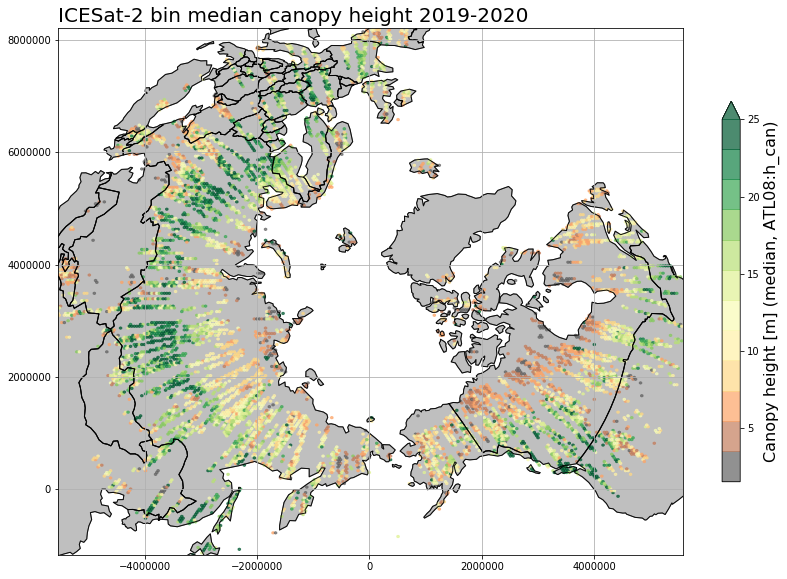

In [31]:
# Exploring ATL08 with hexbins
# All years
ax_map_title = "ICESat-2 bin median canopy height "
cbar_map_title = 'Canopy height [m] (median, ATL08:h_can)'

d = datetime.date.today().strftime("%Y%b%d")
# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(1,1, figsize=(14,10), sharex=True, sharey=True)

bbox = atl08_gdf_aea.total_bounds

group_tmp = atl08_gdf_aea[atl08_gdf_aea.seg_snow == 'snow free land'] 

world_atl08_aea.plot(ax=ax, facecolor='grey', edgecolor='black',  alpha=0.5)
hb = ax.hexbin(group_tmp.geometry.x, group_tmp.geometry.y, C=group_tmp['h_can'], 
                   reduce_C_function=np.median, gridsize=250, cmap=forest_ht_cmap, vmax=25, mincnt=1, alpha=0.7)
world_atl08_aea.plot(ax=ax, facecolor='None', edgecolor='black',  alpha=0.9)

cbar = plt.colorbar(hb, extend='max', spacing='proportional', orientation='vertical', shrink=0.7, format="%.0f")
cbar.set_label(label = cbar_map_title, size=16)
   
ax.set_xlim(bbox[[0,2]])
ax.set_ylim(bbox[[1,3]])
ax.set_title(ax_map_title+"2019-2020", size=20, loc='left')
ax.grid()
fig_fn = os.path.join(DPS_OUTPUT_DIR, 'atl08_alb_h_can_2019_2020_'+d+'.png')
print(fig_fn)
#plt.savefig(fig_fn)

#ax.set(aspect='equal')

In [21]:
print(ctx.providers.keys())
print(ctx.providers.Stamen.keys())

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])
dict_keys(['Toner', 'TonerBackground', 'TonerHybrid', 'TonerLines', 'TonerLabels', 'TonerLite', 'Watercolor', 'Terrain', 'TerrainBackground', 'TopOSMRelief', 'TopOSMFeatures'])


Filtering by year for clear skies


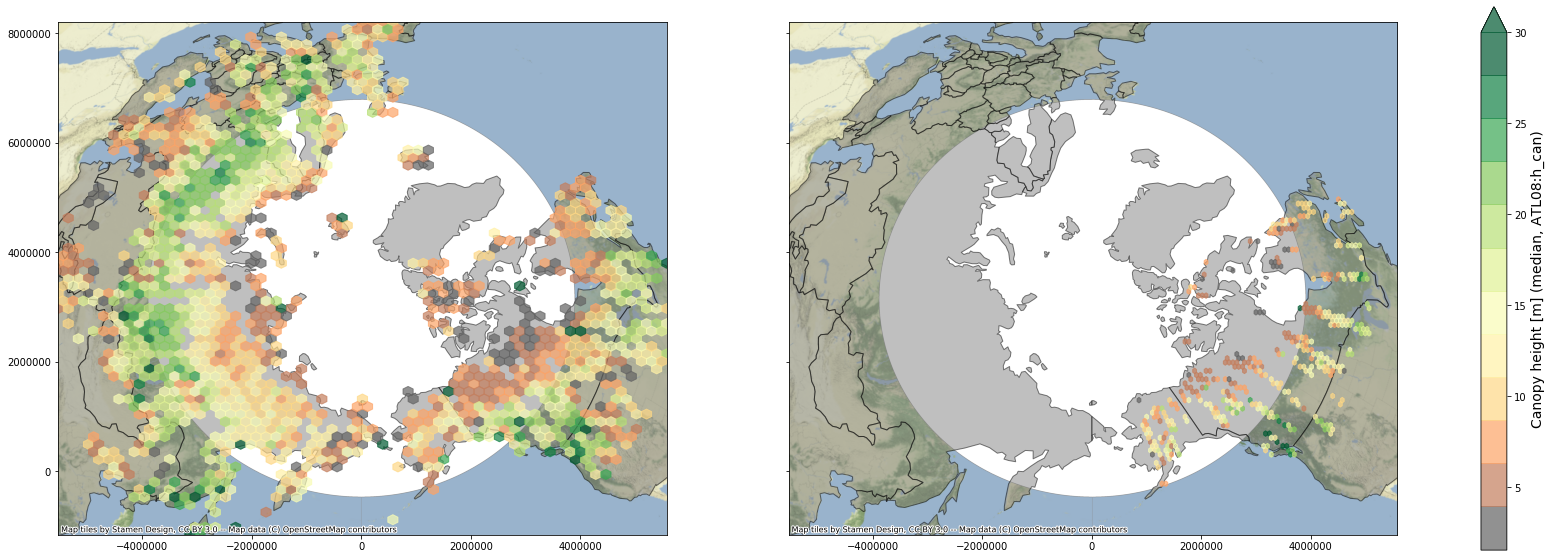

In [32]:
# Exploring ATL08 with hexbins

def add_basemap(ax, crs, zoom='auto'):
    ctx.add_basemap(ax=ax, crs=crs, source=ctx.providers.Stamen.TerrainBackground, zoom=zoom) # ctx.sources.ST_TERRAIN
    #Create a scalebar object, with scaling factor of 1.0 px, since we're using projected coordinate system with unit 1 m
    #scalebar = ScaleBar(1.0)
    #Add scalebar to axes
    #ax.add_artist(scalebar)

bbox = atl08_gdf_aea.total_bounds

# Set up correct number of subplots, space them out. 
fig, ax = plt.subplots(ncols=atl08_gdf_aea.yr.nunique(), figsize=(30,10), sharex=True, sharey=True)

print(f"Filtering by year for clear skies")
for i, (lab, group) in enumerate(atl08_gdf_aea.groupby('yr')):
    
    world_atl08_aea.plot(ax=ax[i], facecolor='grey', edgecolor='black',  alpha=0.5)
    
    group_tmp = group[group.msw_flg == 0]
    
    hb = ax[i].hexbin(group_tmp.geometry.x, group_tmp.geometry.y, C=group_tmp['h_can'], reduce_C_function=np.median, gridsize=60, cmap=forest_ht_cmap, vmax=30, mincnt=1, alpha=0.7)
    
    #world_atl08_aea.plot(ax=ax[i], facecolor='None', edgecolor='black',  alpha=0.9)
    
    ax[i].set_xlim(bbox[[0,2]])
    ax[i].set_ylim(bbox[[1,3]])
    #ax[i].set_title(ax_map_title+lab, size=20, loc='left')
    #ax[i].grid()
    ax[i].set(aspect='equal')
    add_basemap(ax[i], crs=proj)
    
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.5])
#cbar = fig.colorbar(hb, cax=cbar_ax)
#fig.colorbar(im, ax=axes.ravel().tolist())
cbar = plt.colorbar(hb, ax=ax.ravel().tolist(), extend='max', spacing='proportional', orientation='vertical', shrink=1, format="%.0f")
cbar.set_label(label = cbar_map_title, size=14)
#plt.tight_layout() 

In [ ]:
# Get a DEM for study domain
import os
import requests
import rasterio as rio
from rasterio import plot

#bbox_ll = [-150, 55, -115, 70]
#demtype = "SRTMGL3"
#url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff".format(demtype,*bbox_ll)
#response = requests.get(url)
#src = rio.open(response.content)